# Assignment Description

The goal of this assignment is to construct, analyze, and publish a dataset of monthly article traffic for a select set of pages from English Wikipedia from January 1, 2015 through September 30, 2022. This notebook and data files are uploaded to a GitHub repository. The purpose of the assignment was to develop and follow best practices for open scientific research reviewing "Assessing Reproducibility" and "The Basic Reproducible Workflow Template" from The Practice of Reproducible Research.

# Step 1: Data Acquisition

In order to measure article traffic from 2015-2022, you will need to collect data from the Pageviews API. The Pageviews API (documentation, endpoint) provides access to desktop, mobile web, and mobile app traffic data from July 2015 through the previous complete month.

To get you started, you can refer to this example notebook that contains sample code for the API call. This sample code is licensed CC0 so feel free to reuse any of the code in that notebook without attribution.

You will be collecting counts of pageviews using a specified subset of Wikipedia article pages. This is a subset of the English Wikipedia that represents a large number of dinosaur related articles.

You will use the same article subset to generate several related data sets. All of the data sets are time series of monthly activity. For all of the data sets we are only interested in actual user pageview requests. The three resulting datasets should be saved as a JSON files ordered using article titles as a key for the resulting time series data. You should store the time series data as returned from the API, with the exception of removing the ‘access’ field as it is misleading for mobile and cumulative files.


#### Brief overview of the approach:
In this phase we will configure the REST API endpoints for downloading the data to start with, then download the data for different access types followed by filtering, manipulating and transforming required fields into saving different JSONs - mobile, desktop, cumulative.

## Import required libraries

In [42]:
# These are standard python modules for dealing with json and time objects and REST APIs and regular expressions
import json, time, urllib.parse, re

# The 'requests' module is not a standard Python module. You will need to install this with pip/pip3 if you do not already have it
import requests

# Standard libraries for dataframe, numpy array loading and manipulation and plotting graphs and other standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings

### Create required directory structure

In [2]:
os.makedirs('./json_outputs', exist_ok=True)
os.makedirs('./intermediate_outputs', exist_ok=True)
os.makedirs('./plotted_graphs', exist_ok=True)

### Step 1.1: Configure the REST API endpoint and required global parameters

Declaring global parameters in a single cell at the start of the notebook which is a good practice

In [43]:
# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include a "unique ID" that will allow them to
# contact you if something happens - such as - your code exceeding request limits - or some other error happens
REQUEST_HEADERS = {
    'User-Agent': 'rlokwani@uw.edu, University of Washington, MSDS DATA 512 - AUTUMN 2022',
}

# This template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request. The dictionary has a
# field/key for each of the required parameters. In the example, below, we only vary the article name, so the majority of the fields
# can stay constant for each request. Of course, these values *could* be changed if necessary.
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "desktop",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015010100",
    "end":         "2022093000"    # this is likely the wrong end date
}

# Defining different paths
JSON_PATH='./json_outputs/'
INTERMEDIATE_OUTPUTS_PATH='./intermediate_outputs/'
PLOTTED_GRAPHS_PATH='./plotted_graphs/'
INPUT_DATA_PATH='./input_data/'

#Setting warnings parameter to avoid repetitive logging
warnings.filterwarnings(action='once')

Defining required functions for getting the pageviews data. Important parameters in the function call were article_title and request template which we change for each request that we make to the REST API

In [4]:
def request_pageviews_per_article(article_title = None, 
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT, 
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS, 
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  headers = REQUEST_HEADERS):
    # Make sure we have an article title
    if not article_title: return None
    
    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(article_title.replace(' ','_'))
    request_template['article'] = article_title_encoded
    
    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)
    
    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response


You will produce three files as follows:
    Monthly mobile access - The API separates mobile access types into two separate requests, you will need to sum these to make one count for all mobile pageviews. You should store the mobile access data in a file called: dino_monthly_mobile_<startYYYYMM>-<endYYYYMM>.json
    
    Monthly desktop access - Monthly desktop page traffic is based on one single request. You should store the desktop access data in a file called: dino_monthly_desktop_<startYYYYMM>-<endYYYYMM>.json
    
    Monthly cumulative - Monthly cumulative data is the sum of all mobile, and all desktop traffic per article. You should store the monthly cumulative data in a file called: dino_monthly_cumulative_<startYYYYMM>-<endYYYYMM>.json

    For all of the files the <startYYYYMM> and <endYYYYMM> represent the starting and ending year and month as integer text.
    
Additonal function of saving the json as per the access type and in the required format as expected.

In [5]:
def save_json(access, df, startdate, enddate):
    print ("Saving json for: ", access)
    
    result = df.to_json(orient='records')[1:-1].replace('},{', '} {')
    result = '['+result+']'
    result = re.sub("}\s{", "},{", result)
    
    json_string = json.loads(result)         #Loads json string object
    json_object = json.dumps(json_string, indent=4)    #String as a json data object

    path = JSON_PATH + 'dino_monthly_'+access+'_'+startdate+'-'+enddate+'.json'
    
    with open(path, 'w') as f:
        f.write(json_object)              #Opening the file object and saving the json


#### Load relevant data

In [6]:
articles_dataframe=pd.read_csv(INPUT_DATA_PATH+'dinosaur_genera.cleaned.SEPT.2022 - dinosaur_genera.cleaned.SEPT.2022.csv.csv', encoding='utf8')
articles_dataframe.head()

,name,url
0,“Coelosaurus” antiquus,https://en.wikipedia.org/wiki/”Coelosaurus”_an...
1,Aachenosaurus,https://en.wikipedia.org/wiki/Aachenosaurus
2,Aardonyx,https://en.wikipedia.org/wiki/Aardonyx
3,Abdarainurus,https://en.wikipedia.org/wiki/Abdarainurus
4,Abditosaurus,https://en.wikipedia.org/wiki/Abditosaurus


In [7]:
# Getting article names and modifying for specific symbols to make it callable with the REST API

ARTICLE_TITLES=list(articles_dataframe['name'])
ARTICLE_TITLES=[title.replace("“", '').replace("”", '') for title in ARTICLE_TITLES]

## 1.2 Get data by calling the API

Getting the data for each of the access types by changing the ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE dictionary and then adding it to a dataframe. This data can be parsed as a JSON but due to pandas supporting quicker and streamlined operations, we will be converting json objects to dataframes and then run all the transformations/manipulations on them.

In [12]:
view_type_list = ['mobile-app', 'mobile-web','desktop']
data_df = []
for title_id, title in enumerate(ARTICLE_TITLES):
    for access_type in view_type_list:
        try:
            ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE['access'] = access_type   #Setting the access type
            views_dict = request_pageviews_per_article(article_title = title, request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE) #Making requests to the API
            data_df.append(pd.json_normalize(views_dict['items']))
        except:
            print ("Data not found for "+title+" for access type: "+access_type)
    #print ("Page view data download in progress: ", title)

views_dinosaurs_df = pd.concat(data_df) #Concating the data stored as list of dataframes to a single master dataframe

## 1.3  Saving the Data

In [ ]:
views_dinosaurs_df.columns
views_dinosaurs_df.to_csv(INTERMEDIATE_OUTPUTS_PATH+'dinosaurs_data.csv', index=None)   #Saving the entire 

In [13]:
views_dinosaurs_df=pd.read_csv(INTERMEDIATE_OUTPUTS_PATH+'dinosaurs_data.csv')      #Reading step after the above checkpoint CSV
views_dinosaurs_df.head()

,project,article,granularity,timestamp,access,agent,views
0,en.wikipedia,Coelosaurus_antiquus,monthly,2015070100,mobile-app,user,4
1,en.wikipedia,Coelosaurus_antiquus,monthly,2015080100,mobile-app,user,2
2,en.wikipedia,Coelosaurus_antiquus,monthly,2015090100,mobile-app,user,2
3,en.wikipedia,Coelosaurus_antiquus,monthly,2015100100,mobile-app,user,0
4,en.wikipedia,Coelosaurus_antiquus,monthly,2015110100,mobile-app,user,0


### 1.3.1 Save Mobile Data

In [14]:
# Filtering the data for two access types: mobile-app and mobile-web
df_mobile=views_dinosaurs_df[(views_dinosaurs_df['access']=='mobile-app') | (views_dinosaurs_df['access'] == 'mobile-web')]
df_mobile=df_mobile.drop(columns=['access'])
df_mobile.head()

,project,article,granularity,timestamp,agent,views
0,en.wikipedia,Coelosaurus_antiquus,monthly,2015070100,user,4
1,en.wikipedia,Coelosaurus_antiquus,monthly,2015080100,user,2
2,en.wikipedia,Coelosaurus_antiquus,monthly,2015090100,user,2
3,en.wikipedia,Coelosaurus_antiquus,monthly,2015100100,user,0
4,en.wikipedia,Coelosaurus_antiquus,monthly,2015110100,user,0


In [15]:
mobile_columns = df_mobile.columns.to_list()
mobile_columns.remove('views')
df_mobile_2 = df_mobile.groupby(mobile_columns).agg({'views': np.sum}).reset_index() #Aggregating the views from two access types
df_mobile_2.head()

,project,article,granularity,timestamp,agent,views
0,en.wikipedia,Aachenosaurus,monthly,2015070100,user,443
1,en.wikipedia,Aachenosaurus,monthly,2015080100,user,412
2,en.wikipedia,Aachenosaurus,monthly,2015090100,user,283
3,en.wikipedia,Aachenosaurus,monthly,2015100100,user,794
4,en.wikipedia,Aachenosaurus,monthly,2015110100,user,311


In [16]:
start_date=str(np.min(df_mobile_2['timestamp']))[:6]
end_date=str(np.max(df_mobile_2['timestamp']))[:6]
save_json('mobile', df_mobile_2, start_date, end_date) #Calling the above function to store data in required format

Saving json for:  mobile


### 1.3.2 Save Desktop Data

In [17]:
# Filtering the data for 'desktop' access type

df_desktop=views_dinosaurs_df[(views_dinosaurs_df['access']=='desktop')]
df_desktop=df_desktop.drop(columns=['access'])
df_desktop.head()

,project,article,granularity,timestamp,agent,views
174,en.wikipedia,Coelosaurus_antiquus,monthly,2015070100,user,79
175,en.wikipedia,Coelosaurus_antiquus,monthly,2015080100,user,62
176,en.wikipedia,Coelosaurus_antiquus,monthly,2015090100,user,80
177,en.wikipedia,Coelosaurus_antiquus,monthly,2015100100,user,66
178,en.wikipedia,Coelosaurus_antiquus,monthly,2015110100,user,72


In [18]:
start_date=str(np.min(df_desktop['timestamp']))[:6]
end_date=str(np.max(df_desktop['timestamp']))[:6]
save_json('desktop', df_desktop, start_date, end_date) #Calling the above function to store data in required format

Saving json for:  desktop


### 1.3.3 Save Cumulative data

In [19]:
# Merge the dataframe to ease summing of views
df_cumulative = pd.merge(df_mobile_2, df_desktop, on=['article', 'timestamp'], how='outer')
df_cumulative.head()

,project_x,article,granularity_x,timestamp,agent_x,views_x,project_y,granularity_y,agent_y,views_y
0,en.wikipedia,Aachenosaurus,monthly,2015070100,user,443,en.wikipedia,monthly,user,2671
1,en.wikipedia,Aachenosaurus,monthly,2015080100,user,412,en.wikipedia,monthly,user,13113
2,en.wikipedia,Aachenosaurus,monthly,2015090100,user,283,en.wikipedia,monthly,user,34235
3,en.wikipedia,Aachenosaurus,monthly,2015100100,user,794,en.wikipedia,monthly,user,5361
4,en.wikipedia,Aachenosaurus,monthly,2015110100,user,311,en.wikipedia,monthly,user,13502


In [20]:
# Sum the views from mobile and desktop and then drop required columns
df_cumulative['views']=df_cumulative['views_x']+df_cumulative['views_y']
df_cumulative=df_cumulative.drop(columns=['project_y', 'granularity_y', 'agent_y', 'views_y', 'views_x'])
df_cumulative.columns=['project','article', 'granularity', 'timestamp','agent', 'views']
df_cumulative.head()

,project,article,granularity,timestamp,agent,views
0,en.wikipedia,Aachenosaurus,monthly,2015070100,user,3114
1,en.wikipedia,Aachenosaurus,monthly,2015080100,user,13525
2,en.wikipedia,Aachenosaurus,monthly,2015090100,user,34518
3,en.wikipedia,Aachenosaurus,monthly,2015100100,user,6155
4,en.wikipedia,Aachenosaurus,monthly,2015110100,user,13813


In [22]:
articles=np.unique(df_cumulative['article'])
final_cumulative_df=pd.DataFrame(columns=df_cumulative.columns)

for title in articles:
    current_df=df_cumulative.loc[df_cumulative['article']==title]     #Filter for each article
    current_df['views']=current_df['views'].cumsum()                 #Take a monthly cumulative sum per article
    
    final_cumulative_df=pd.concat([final_cumulative_df, current_df])
    
    #print ("Cumulative views calculated for: ", title)
final_cumulative_df.head()

,project,article,granularity,timestamp,agent,views
0,en.wikipedia,Aachenosaurus,monthly,2015070100,user,3114
1,en.wikipedia,Aachenosaurus,monthly,2015080100,user,16639
2,en.wikipedia,Aachenosaurus,monthly,2015090100,user,51157
3,en.wikipedia,Aachenosaurus,monthly,2015100100,user,57312
4,en.wikipedia,Aachenosaurus,monthly,2015110100,user,71125


In [23]:
start_date=str(np.min(final_cumulative_df['timestamp']))[:6]
end_date=str(np.max(final_cumulative_df['timestamp']))[:6]
save_json('cumulative', final_cumulative_df, start_date, end_date)        #Store the ouput in the required format

Saving json for:  cumulative


### Read  JSON file to a dataframe

In [24]:
mobile_data_filename=JSON_PATH+'dino_monthly_mobile_'+start_date+'-'+end_date+'.json'
mobile_data_file_object = open(mobile_data_filename)
mobile_data_json_object = json.load(mobile_data_file_object)
df_mobile = pd.json_normalize(mobile_data_json_object)
df_mobile.head()

,project,article,granularity,timestamp,agent,views
0,en.wikipedia,Aachenosaurus,monthly,2015070100,user,443
1,en.wikipedia,Aachenosaurus,monthly,2015080100,user,412
2,en.wikipedia,Aachenosaurus,monthly,2015090100,user,283
3,en.wikipedia,Aachenosaurus,monthly,2015100100,user,794
4,en.wikipedia,Aachenosaurus,monthly,2015110100,user,311


In [25]:
desktop_data_filename=JSON_PATH+'dino_monthly_desktop_'+start_date+'-'+end_date+'.json'
desktop_data_file_object = open(desktop_data_filename)
desktop_data_json_object = json.load(desktop_data_file_object)
df_desktop = pd.json_normalize(desktop_data_json_object)
df_desktop.head()

,project,article,granularity,timestamp,agent,views
0,en.wikipedia,Coelosaurus_antiquus,monthly,2015070100,user,79
1,en.wikipedia,Coelosaurus_antiquus,monthly,2015080100,user,62
2,en.wikipedia,Coelosaurus_antiquus,monthly,2015090100,user,80
3,en.wikipedia,Coelosaurus_antiquus,monthly,2015100100,user,66
4,en.wikipedia,Coelosaurus_antiquus,monthly,2015110100,user,72


# Step 2: Analysis

You will conduct a very basic visual analysis. The analysis for this homework is to graph specific subsets of the data as a timeseries. You will produce three different graphs.


## Step 2.1: Maximum Average and Minimum Average 

The first graph should contain time series for the articles that have the highest average page requests and the lowest average page requests for desktop access and mobile access. Your graph should have four lines (max desktop, min desktop, max mobile, min mobile).


Module that processes the data to get maximum and minimum average. Steps involved:
1. Aggregate articles by views and take an average
2. Find the maximum and minimum average using in-built pandas functions
3. Obtain the data for each of the access types
4. Add a category tag to differentiate while plotting and return the data

In [26]:
def data_processing_max_min_average(dataframe, access):
    mean_df = dataframe.groupby("article").mean('views') #Grouping by the means of articles over months
    
    #There could be possibilities of timestamps in different formats. We just handle it using exceptions using here.
    try:
        dataframe['timestamp'] = pd.to_datetime(dataframe['timestamp'].astype('str'), format='%Y-%m-%d')
    except:
        dataframe['timestamp'] = pd.to_datetime(dataframe['timestamp'].astype('str'), format='%Y%m%d%H')
        
    max_views = mean_df.loc[mean_df['views'].idxmax()].name
    min_views = mean_df.loc[mean_df['views'].idxmin()].name
    print(max_views, min_views)
    
    # Filter the articles-related dara
    max_df = dataframe[dataframe['article'] == max_views][['article', 'timestamp', 'views']]
    min_df = dataframe[dataframe['article'] == min_views][['article', 'timestamp', 'views']]
    
    # Categorize using access and the required conditions
    max_df['category'] = 'max_' + access
    max_df['label'] = max_df['article'] + '[' + max_df['category'] + ']'
    min_df['category'] = 'min_' + access
    min_df['label'] = min_df['article'] + '[' + min_df['category'] + ']'

    df=pd.concat([max_df, min_df])        #Concatenating dataframes to get the master plotting data frames
    
    return df

In [27]:
# Call the above function for both access types, concatenate and create a master data for plotting
desktop_data = data_processing_max_min_average(df_desktop, access = 'desktop')
mobile_data = data_processing_max_min_average(df_mobile, access = 'mobile')

df_plot = pd.concat([desktop_data, mobile_data])
df_plot = df_plot.set_index('timestamp')

Tyrannosaurus Honghesaurus
Tyrannosaurus Honghesaurus


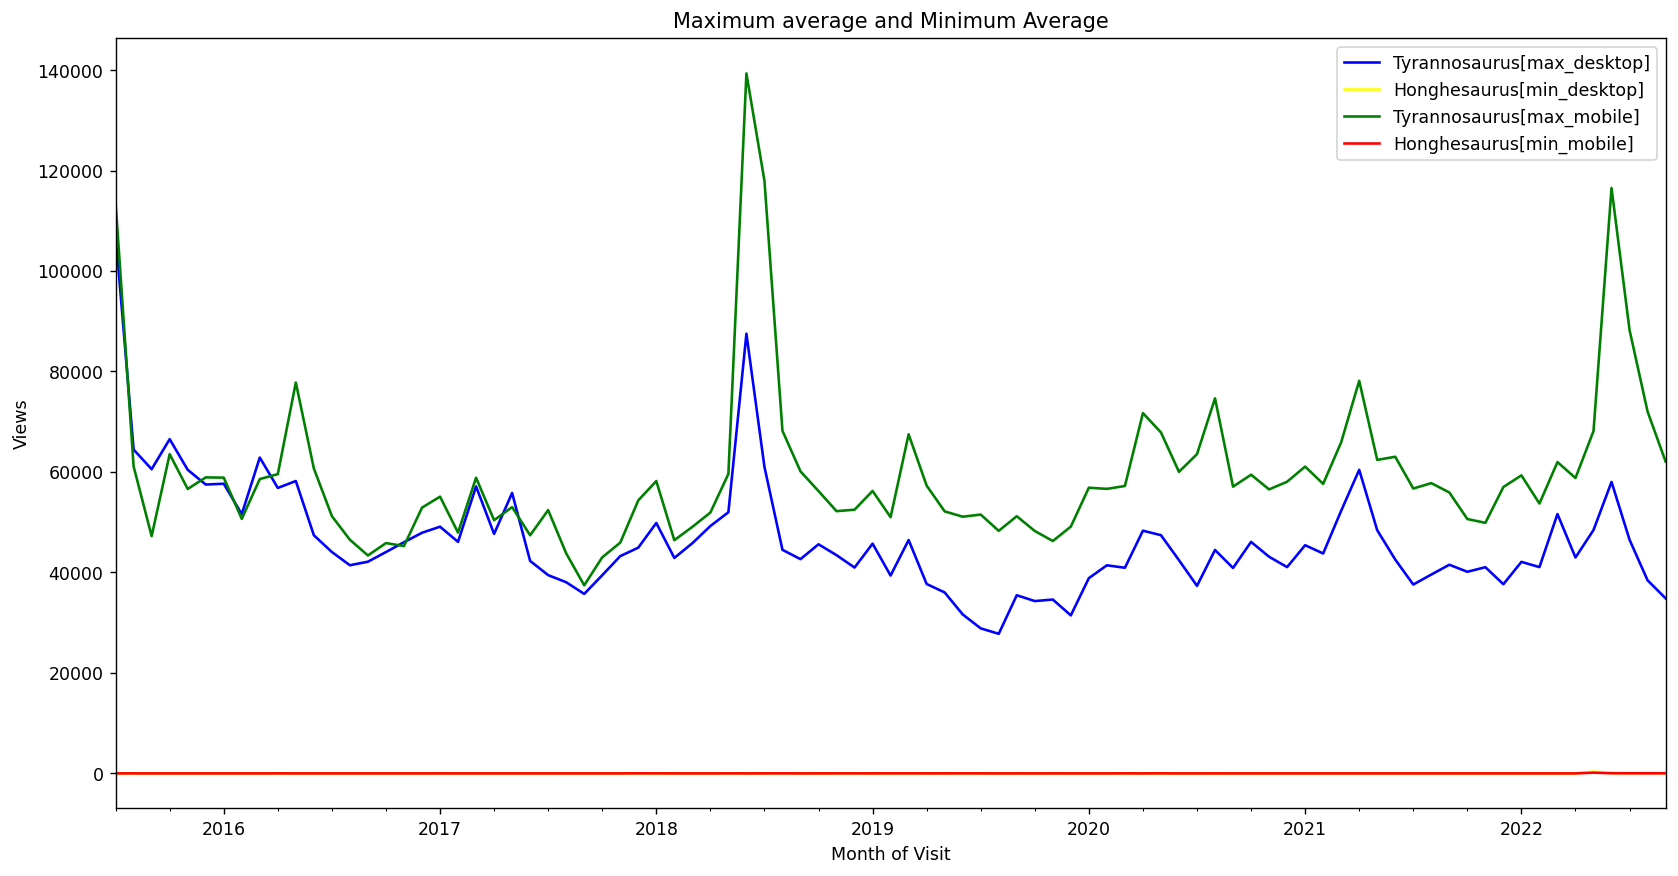

In [28]:
plt.figure(figsize=(16, 8), dpi=125)

#Plot individual line graphs on the figure
df1 = df_plot[df_plot['category'] == 'max_desktop']
df1['views'].plot(label=df1['label'].unique()[0], color='blue')
df2 = df_plot[df_plot['category'] == 'min_desktop']
df2['views'].plot(label=df2['label'].unique()[0], color='yellow')
df3 = df_plot[df_plot['category'] == 'max_mobile']
df3['views'].plot(label=df3['label'].unique()[0], color='green')
df4 = df_plot[df_plot['category'] == 'min_mobile']
df4['views'].plot(label=df4['label'].unique()[0], color='red')

# adding title, axes and legend to the plot
plt.title('Maximum average and Minimum Average')
plt.xlabel('Month of Visit')
plt.ylabel('Views')
plt.legend()

# Save the plot as a png file
plt.savefig(PLOTTED_GRAPHS_PATH+'top_max_min_average_views.png')

## Step 2.1: Top 10 Peak Page Views

The second graph should contain time series for the top 10 article pages by largest (peak) page views over the entire time by access type. You first find the month for each article that contains the highest (peak) page views, and then order the articles by these peak values. Your graph should contain the top 10 for desktop and top 10 for mobile access (20 lines).


Module to get the articlesthat have the top 10 page views across all the months
Steps followed:
1. Calculate the maximum views across all the months for each article using aggregate max function in pandas
2. Sort and get top 10 and assign them the order number
3. Add a category label as we did in step 2.1 and return the final result

In [29]:
def process_top_ten(dataframe, access):
    
    grouped_df=dataframe.groupby("article").max("views")    # Aggregate and calculate the max value
    top_articles=grouped_df.sort_values(by='views', ascending=False).head(10)  #Sort and get top 10 values
    top_articles['order']=[i for i in range(1,11)]    #Order them from 1 to 10
    
    dataframe = dataframe[['article','timestamp','views']]
    dataframe = dataframe.merge(top_articles, on='article', how = 'inner')     #Inner join two dataframes to get required clolumns
    
    dataframe['category'] = access + '_top_' + dataframe['order'].astype('str') + '(' + dataframe['article'] +')'
    dataframe['access']=access
    dataframe['views']=dataframe['views_x']
    dataframe=dataframe.drop(columns=['views_x', 'views_y'])    #Dropping additional columns
    return dataframe

In [30]:
# Get data for both access types: desktop and mobile
desktop_data = process_top_ten(df_desktop, access = 'desktop')
mobile_data = process_top_ten(df_mobile, access = 'mobile')

df_plot = pd.concat([desktop_data, mobile_data])
df_plot = df_plot.set_index('timestamp')

In [31]:
df_plot.head()

,article,order,category,access,views
timestamp,,,,,
2015-07-01,Achelousaurus,1,desktop_top_1(Achelousaurus),desktop,1181
2015-08-01,Achelousaurus,1,desktop_top_1(Achelousaurus),desktop,703
2015-09-01,Achelousaurus,1,desktop_top_1(Achelousaurus),desktop,699
2015-10-01,Achelousaurus,1,desktop_top_1(Achelousaurus),desktop,708
2015-11-01,Achelousaurus,1,desktop_top_1(Achelousaurus),desktop,691


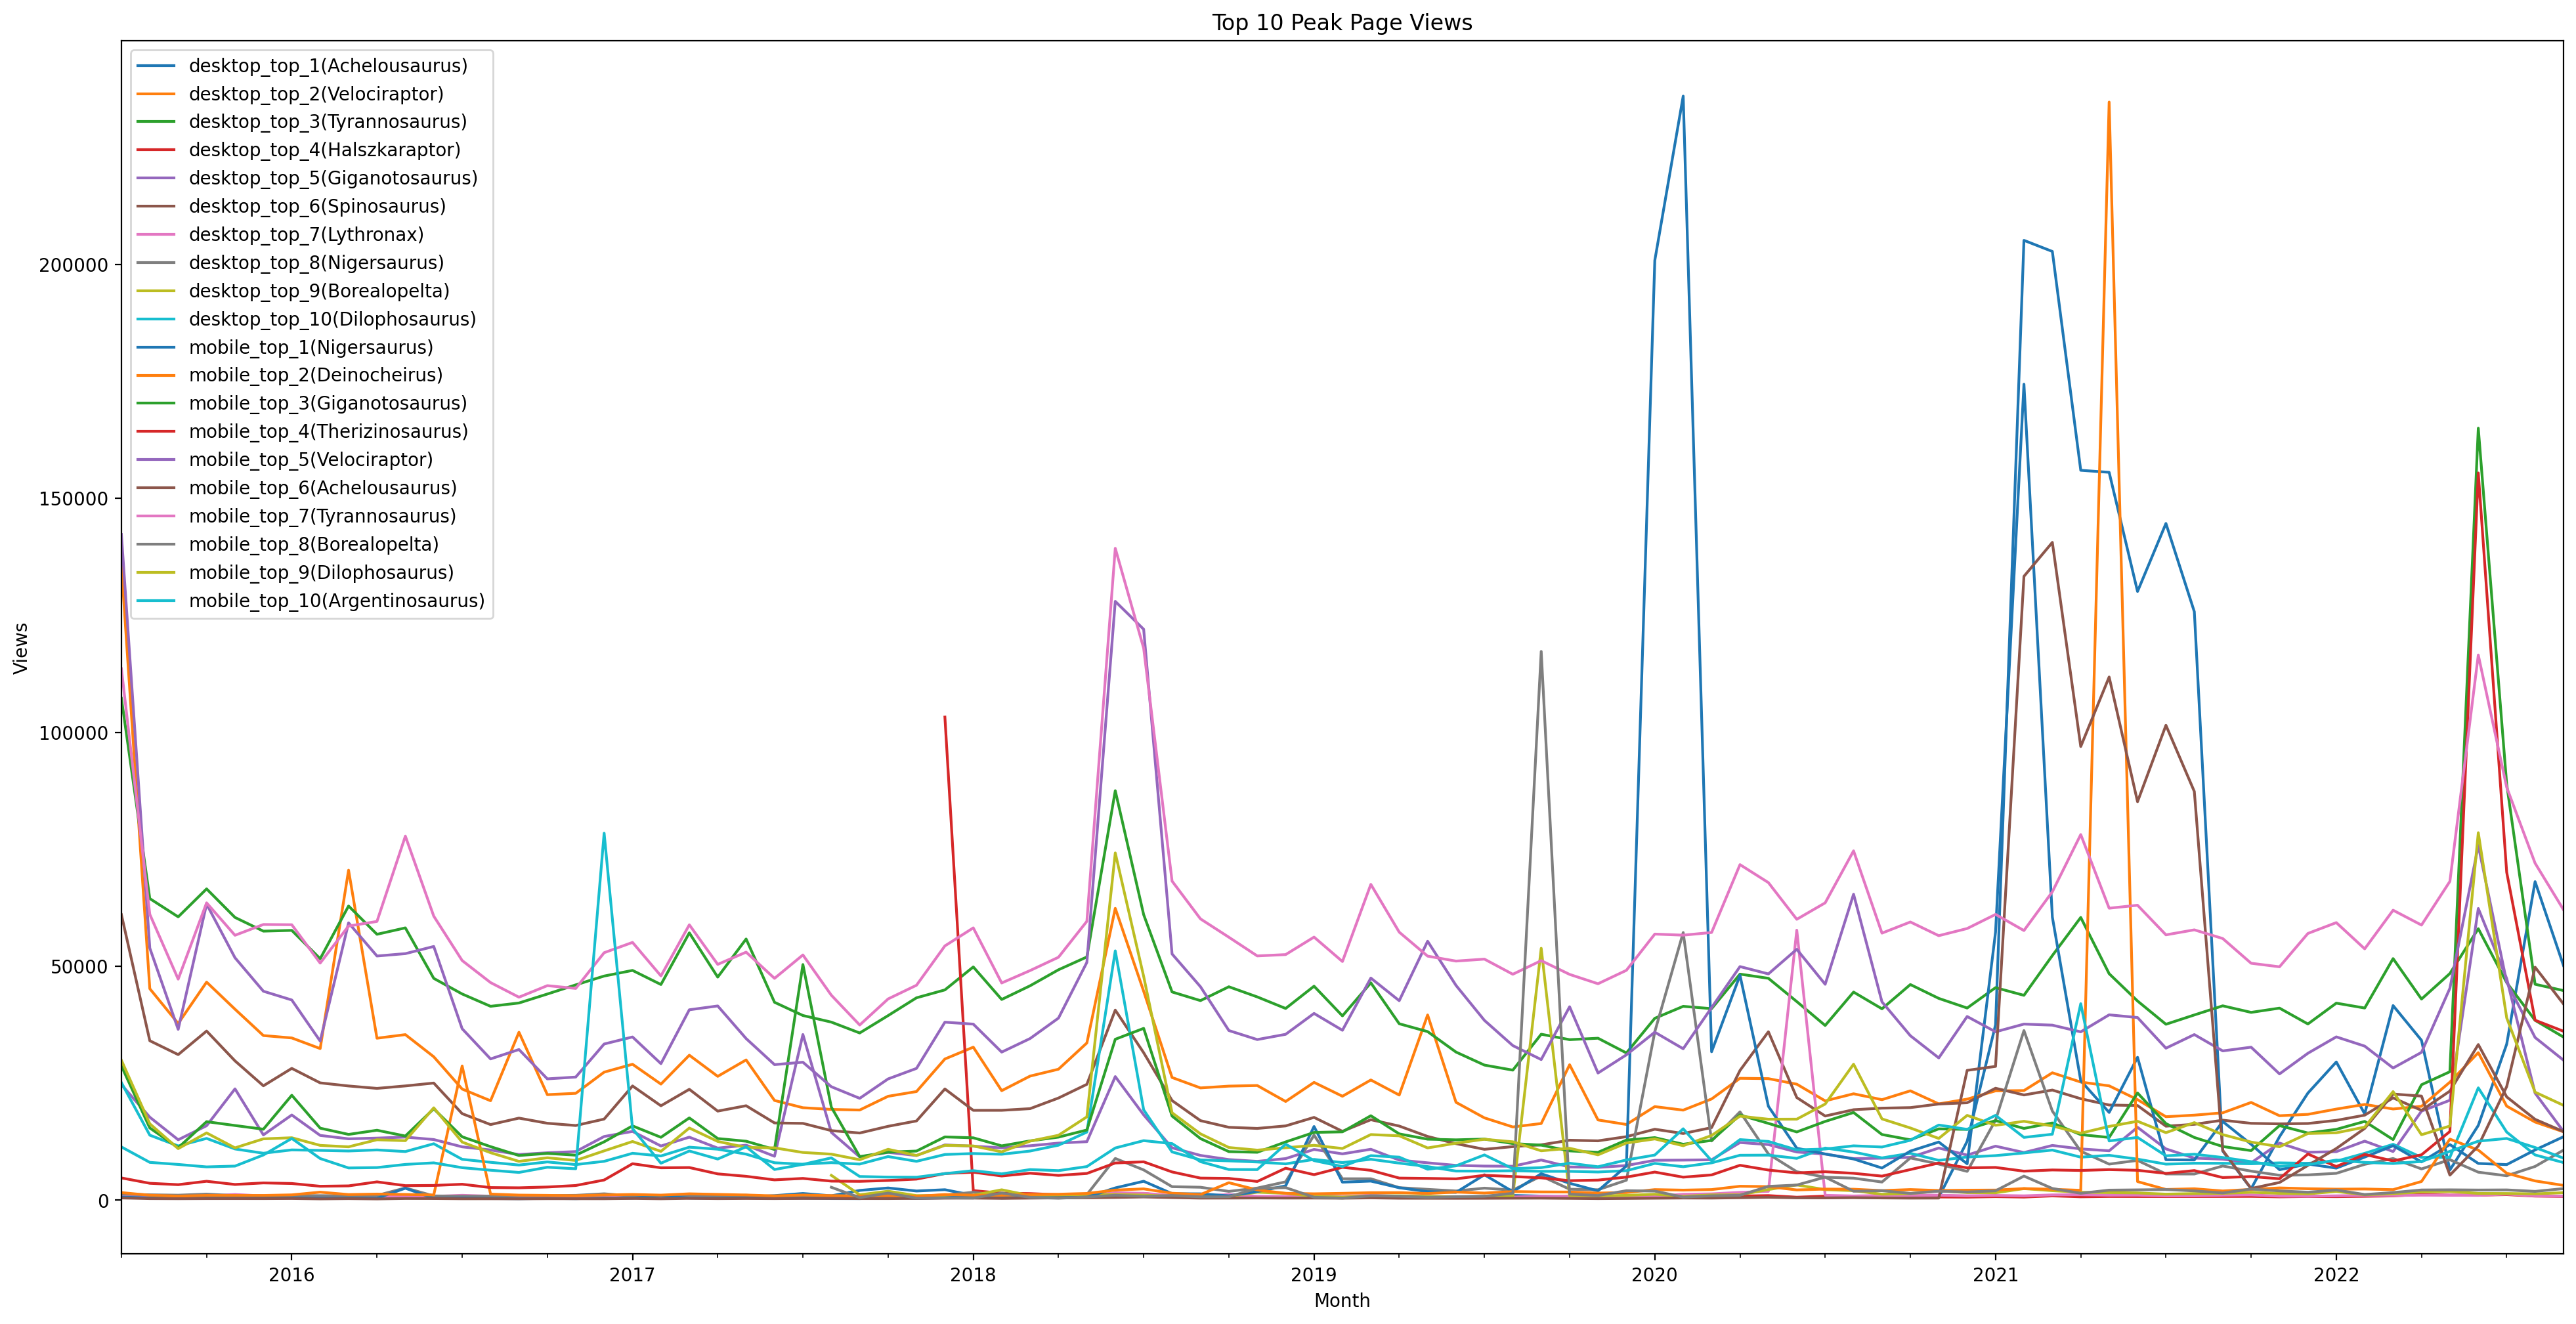

In [35]:
plt.figure(figsize=(24, 12), dpi=200)
  
# Plot the data values and later adding title, axes, legend and save the plot
for i in range(1,11):
    df = df_plot[df_plot['order'] == i]
    df[df['access'] == 'desktop']['views'].plot(label=df['category'].unique()[0])
    
for i in range(1,11):
    df = df_plot[df_plot['order'] == i]
    df[df['access'] == 'mobile']['views'].plot(label=df['category'].unique()[1])
    
plt.title('Top 10 Peak Page Views')
plt.xlabel('Month')
plt.ylabel('Views')
plt.legend()
plt.savefig(PLOTTED_GRAPHS_PATH+'top_ten_page_views.png')

# 2.3 Fewest Months of Data

The third graph should show pages that have the fewest months of available data. These will all be relatively short time series, some may only have one month of data. Your graph should show the 10 articles with the fewest months of data for desktop access and the 10 articles with the fewest months of data for mobile access.

Function to get the articles list that have the fewest months of available data
Steps followed:

1. Calculate the count of months with data available for each article
2. Get the top 10 articles that have the fewest months of data and assign them a rank based on the count of available months
3. Add a category label as we did in step 2.1 and return the final result

In [36]:
def fewest_months_of_dataframe(dataframe = None, access = 'desktop'):
    grouped = dataframe.groupby("article").count().reset_index().iloc[:,0:2]   #Group by and count the number of data points
    grouped = grouped.rename(columns={"project": "count"})  #Change column name to something readable
    least_articles = grouped.sort_values(by='count', ascending=True).head(10)    #Sort and get the bottom 10

    least_articles = least_articles[['article']].reset_index().drop(columns=['index'])
    least_articles['order'] = [i for i in range(1,11)]      #Create rank ordering
    
    dataframe['access'] = access
    dataframe = dataframe[['article', 'timestamp', 'views', 'access']]  #Filter columns to that are required
    
    dataframe = dataframe.merge(least_articles, on='article', how = 'inner')
    dataframe['category'] = access + '_least_freq_' + dataframe['order'].astype('str') + '(' + dataframe['article'] +')' #Create a naming scheme
    return dataframe

In [37]:
# Get data for both access types: desktop and mobile

desktop_data = fewest_months_of_dataframe(df_desktop, access = 'desktop')
mobile_data = fewest_months_of_dataframe(df_mobile, access = 'mobile')

df_plot = pd.concat([desktop_data, mobile_data])
df_plot = df_plot.set_index('timestamp')

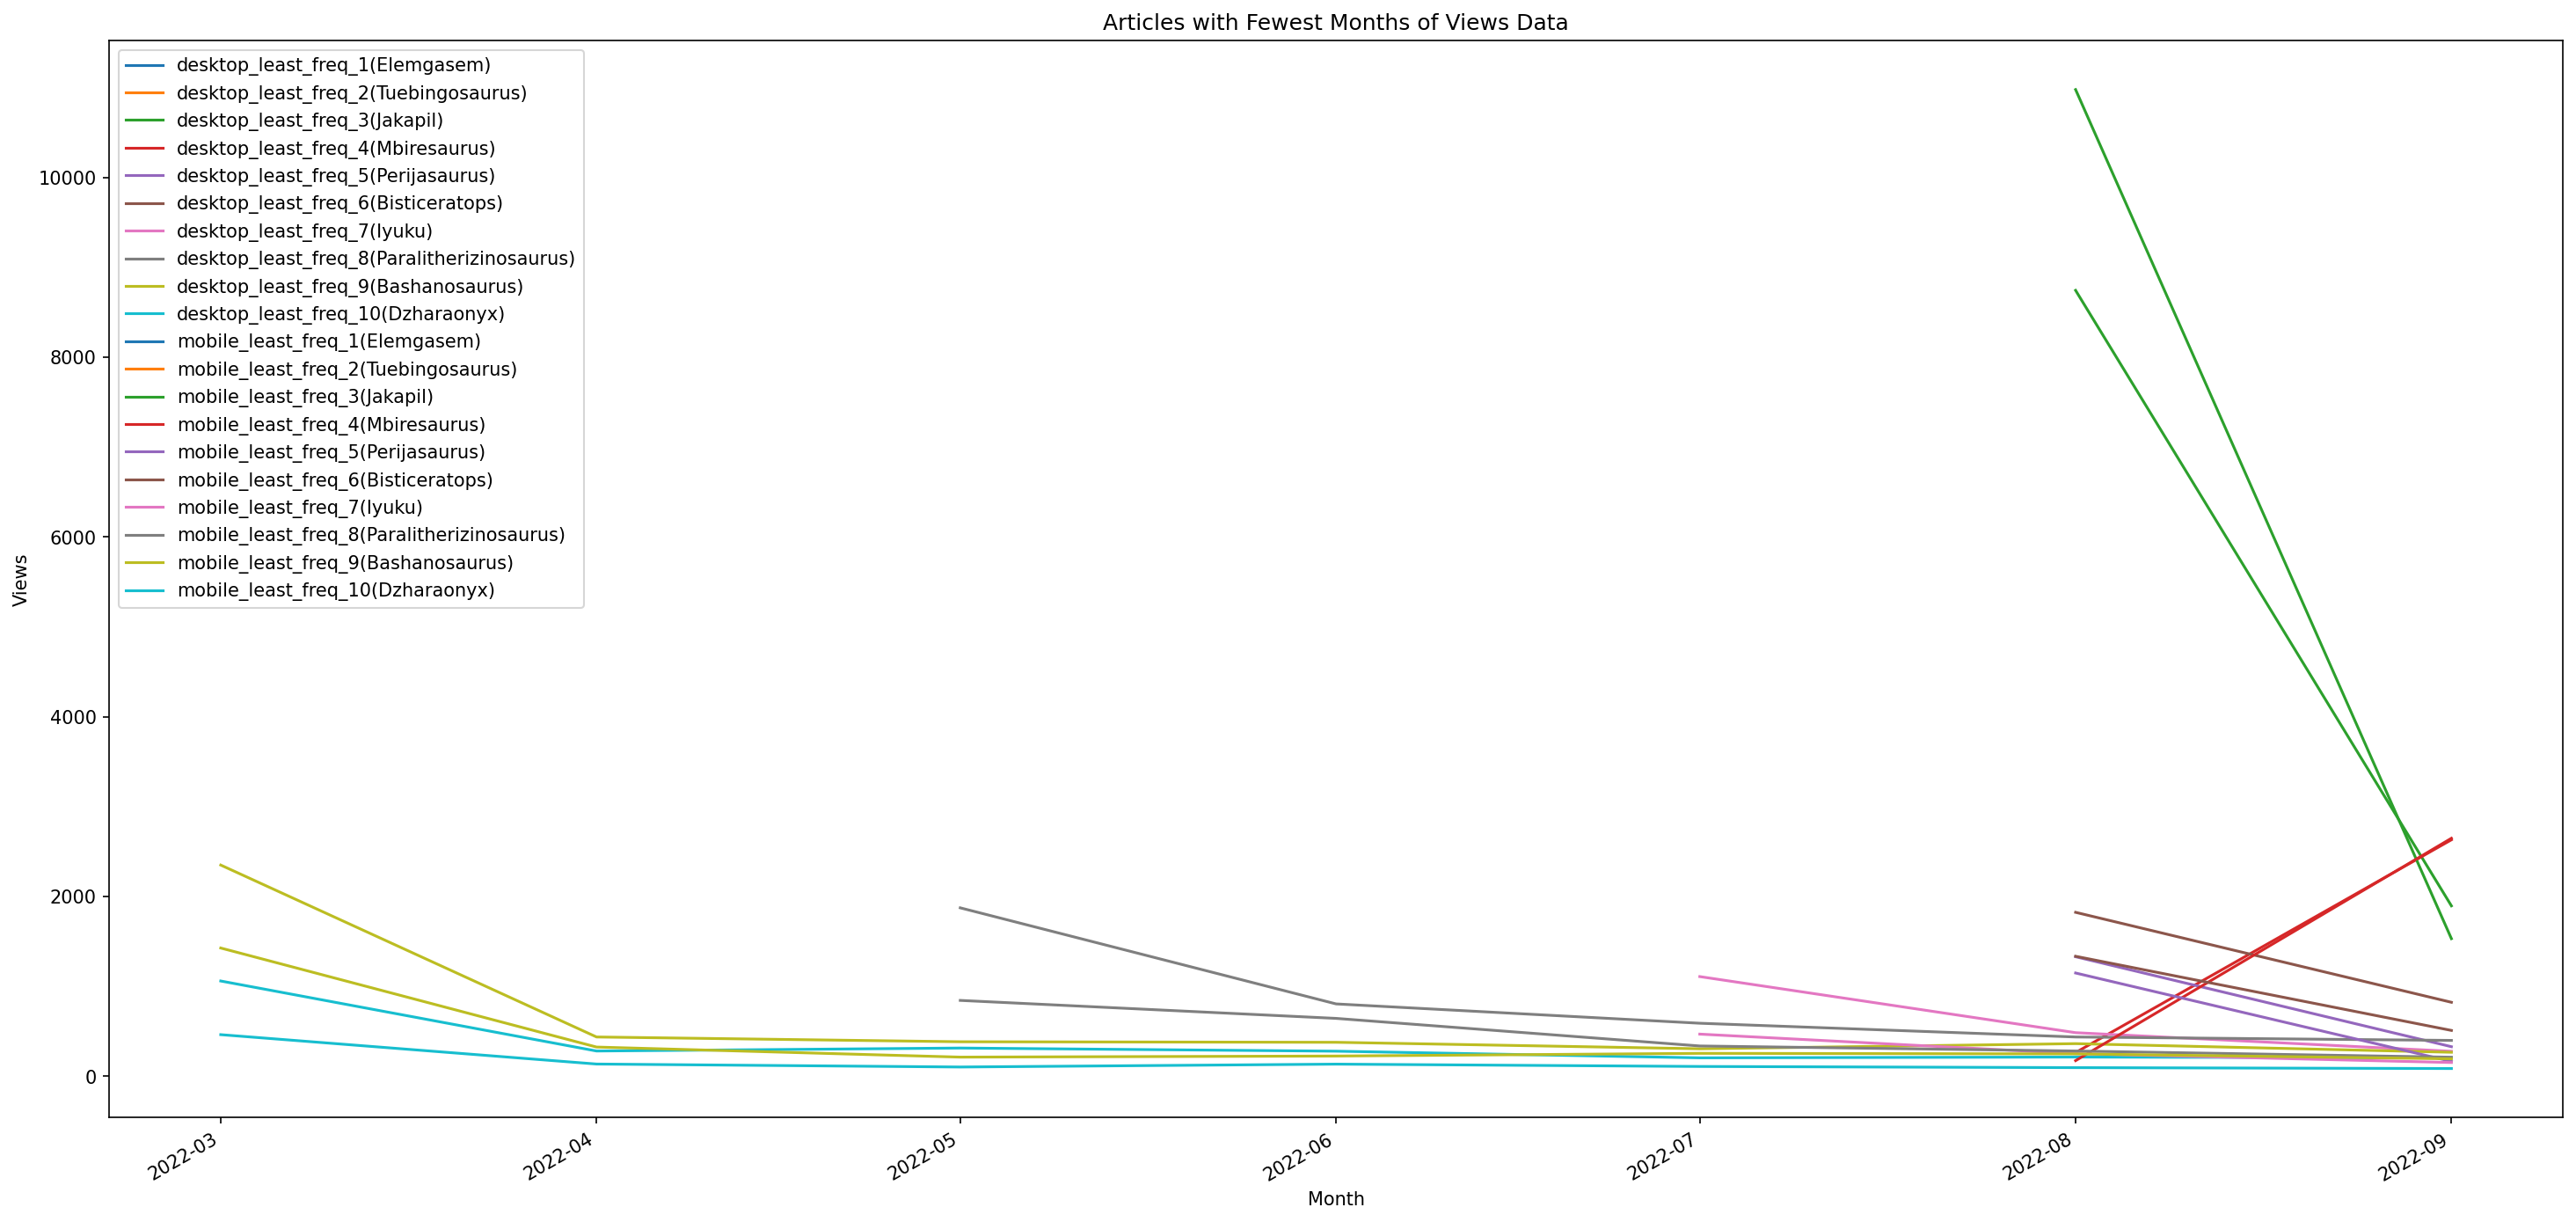

In [40]:
plt.figure(figsize=(24, 12), dpi=150)

for i in range(1,11):
    df = df_plot[df_plot['order'] == i]
    df[df['access'] == 'desktop']['views'].plot(label=df['category'].unique()[0])

for i in range(1,11):
    df = df_plot[df_plot['order'] == i]
    df[df['access'] == 'mobile']['views'].plot(label=df['category'].unique()[1])
    
# adding title to the plot
plt.title('Articles with Fewest Months of Views Data')
plt.xlabel('Month')
plt.ylabel('Views')
plt.legend()

# Save the plot as a png file
plt.savefig(PLOTTED_GRAPHS_PATH+'articles_with_fewest_data_monthly.png')